In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import statsmodels.api as sm

# 모델링
선수의 경기력 지표를 판단하는 건 뭘까?  
target: Win

In [ ]:
batting = pd.read_csv('batting.csv', index_col = 0)

In [ ]:
first_batting = batting[batting['is_debut_year'] == 1]
second_batting = batting[batting['is_debut_year'] == 0]
print(f'1차년도 수: {first_batting.shape}, 2차년도수: {second_batting.shape}')

1차년도 수: (27241, 41), 2차년도수: (23065, 41)


In [ ]:
first_batting.head()

,OT,BO,Po,GS,ePA,AB,R,H,D,T,...,p_no,p_pos,is_debut_year,Win,Scores,home,HS_Graduate,award_year,is_award,date
0,KIA,8,7,1,4,4,1,1,0,0,...,13168,batting,1,1,1,1,1,2018.0,1,2018-03-24
1,KIA,8,7,1,3,3,0,1,0,0,...,13168,batting,1,0,13,1,1,2018.0,1,2018-03-25
2,SK,8,10,1,4,3,2,2,0,0,...,13168,batting,1,0,3,1,1,2018.0,1,2018-03-27
3,SK,2,7,1,5,4,1,2,2,0,...,13168,batting,1,1,3,1,1,2018.0,1,2018-03-28
4,SK,2,10,1,5,5,0,1,0,0,...,13168,batting,1,1,6,1,1,2018.0,1,2018-03-29


## 모델 결과 설명

True Positive (TP): 클래스 1을 정확히 예측한 개수는 3206.
False Negative (FN): 클래스 1을 클래스 0으로 잘못 예측한 개수는 6110.
True Negative (TN): 클래스 0을 정확히 예측한 개수는 6361.
False Positive (FP): 클래스 0을 클래스 1로 잘못 예측한 개수는 3335.
성능 지표:
Precision (정밀도): 모델이 True라고 예측한 것 중 실제 True의 비율. 여기서는 클래스 0의 정밀도가 0.51, 클래스 1의 정밀도가 0.49.
Recall (재현율): 실제 True 중 모델이 True라고 성공적으로 예측한 비율. 클래스 0의 재현율은 0.66, 클래스 1은 0.34.
F1-Score: 정밀도와 재현율의 조화 평균. 클래스 0의 F1-점수는 0.57, 클래스 1은 0.40.

Accuracy (정확도): 전체 예측 중 올바른 예측의 비율은 0.50 (50%)입니다.
이 모델의 정확도는 50%로, 무작위 추측과 유사한 성능을 보입니다. 이는 모델이 두 클래스를 분류하는 데 효과적이지 않음을 의미함. 클래스 0에 대한 재현율은 상대적으로 높으나 (0.66), 클래스 1에 대한 재현율이 낮은데 (0.34). 이는 모델이 클래스 0을 예측하는 데 더 적합하지만, 클래스 1을 정확히 식별하는 데 어려움이 있음을 나타냄.

우린 target 1을 추정하는 것이 더 필요함 (왜냐면 그게 승이니까)


-> pca로 변수 독립성을 줘야겠다!








In [ ]:
X = first_batting.drop(['OT','name','date', 'Win','p_pos','p_no'], axis=1)

y = first_batting['Win']

X_test = second_batting.drop(['OT','name','date', 'Win','p_pos','p_no'], axis=1)
y_test = second_batting['Win']


# StandardScaler 인스턴스 생성
scaler = StandardScaler()
# 테스트 데이터에 대해서는 transform() 사용
X_train =  scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# 로지스틱 회귀 모델 생성 및 훈련
model =  LogisticRegression()
model.fit(X_train, y)

# 모델 평가
predictions = model.predict(X_train)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[6361 3335]
 [6110 3206]]
              precision    recall  f1-score   support

           0       0.51      0.66      0.57      9696
           1       0.49      0.34      0.40      9316

    accuracy                           0.50     19012
   macro avg       0.50      0.50      0.49     19012
weighted avg       0.50      0.50      0.49     19012



## 모델2


### pca

In [ ]:
from sklearn.decomposition import PCA

(array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
        29, 30, 31, 32, 33, 34]),)

pca #(over critical point): 12


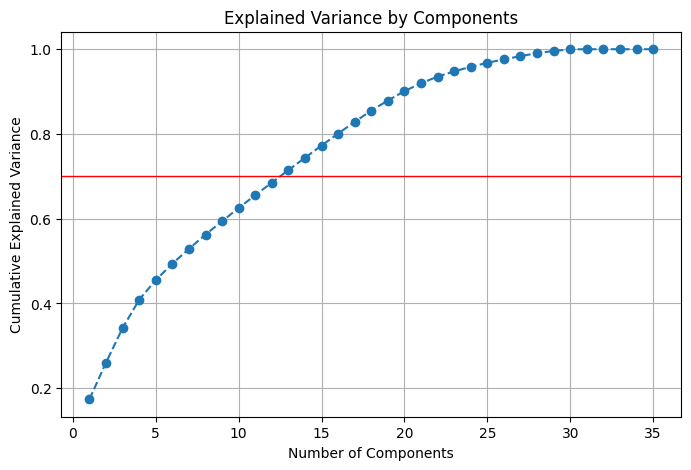

In [ ]:
import numpy as np

# PCA 모델을 사용하여 설명된 분산의 누적 비율 계산
pca = PCA().fit(X_train)
explained_variance_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)

print(f'pca #(over critical point): {np.where(explained_variance_ratio_cumsum > 0.7)[0][0]}')


# 설명된 분산의 누적 비율을 그래프로 표현
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio_cumsum) + 1), explained_variance_ratio_cumsum, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.axhline(y=0.7, color='r', linewidth=1)
plt.show()



In [ ]:
# PCA 모델 생성 및 학습
pca = PCA(n_components=12)  # 축소할 차원 수 설정
X_pca = pca.fit_transform(X_train)


# 결과 확인
print("원본 데이터의 차원: ", X_train.shape[1])
print("축소된 데이터의 차원: ", X_pca.shape[1])

원본 데이터의 차원:  35
축소된 데이터의 차원:  12


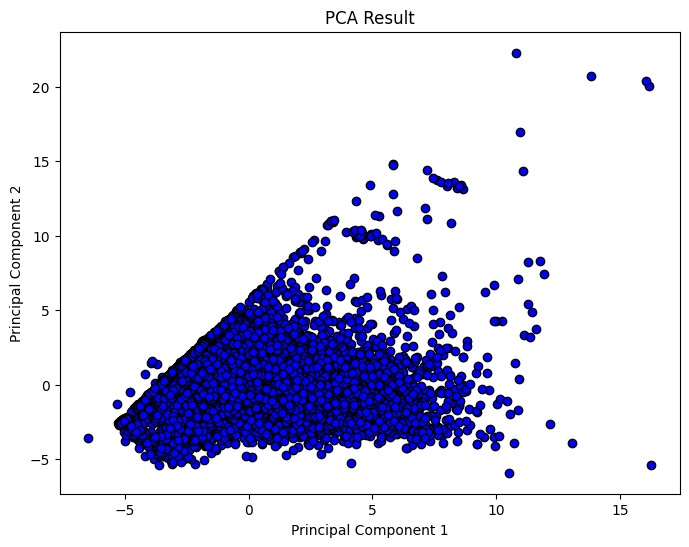

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', marker='o', edgecolor='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Result')
plt.show()

In [ ]:
X_test_scaled_pca = pca.transform(X_test_scaled)
# 로지스틱 회귀 모델 생성 및 훈련
model =  LogisticRegression()
result = model.fit(X_pca, y)

# 모델 평가
predictions = model.predict(X_test_scaled_pca)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[7372 2324]
 [5525 3791]]
              precision    recall  f1-score   support

           0       0.57      0.76      0.65      9696
           1       0.62      0.41      0.49      9316

    accuracy                           0.59     19012
   macro avg       0.60      0.58      0.57     19012
weighted avg       0.60      0.59      0.57     19012



모델은 클래스 0을 예측하는 데 더 높은 재현율을 보여주며, 이는 모델이 클래스 0의 대부분의 사례를 잡아내고 있다는 것을 의미함. 그러나 이로 인해 클래스 1에 대한 많은 False Negatives가 발생하고 있는데,
클래스 1의 경우, 모델은 더 높은 정밀도를 보이지만 재현율이 상대적으로 낮다.   
 이는 모델이 실제 클래스 1을 예측할 때 조심스럽게 예측하나 많은 양의 클래스 1을 놓치고 있음을 의미한다.
모델의 정확도는 59%로, 이는 무작위 추측보다는 낫지만 약간 성능을 높일 필요가 있음.  
클래스별 F1 점수를 볼 때, 클래스 0은 상대적으로 더 높은 성능을 보이지만 클래스 1에 대해서는 개선이 필요함.  
전반적으로, 이 모델은 클래스 0을 예측하는 데는 괜찮은 성능을 보이고 있지만, 클래스 1의 예측 성능은 훨씬 더 개선되어야 할 것으로 보임

In [ ]:
X_test_scaled_pca = pca.transform(X_test_scaled)
# 로지스틱 회귀 모델 생성 및 훈련
model =  sm.Logit(y,X_pca)
result = model.fit(method = 'newton')

# 모델 평가
predictions = result.predict(X_test_scaled_pca)

Optimization terminated successfully.
         Current function value: 0.665590
         Iterations 5


In [ ]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    Win   No. Observations:                19012
Model:                          Logit   Df Residuals:                    19000
Method:                           MLE   Df Model:                           11
Date:                Thu, 28 Mar 2024   Pseudo R-squ.:                 0.03765
Time:                        16:49:13   Log-Likelihood:                -12654.
converged:                       True   LL-Null:                       -13149.
Covariance Type:            nonrobust   LLR p-value:                2.419e-205
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1395      0.006     21.491      0.000       0.127       0.152
x2            -0.0487      0.009     -5.573      0.000      -0.066      -0.032
x3             0.1729      0.009     18.262      0.000       0.154       0.191
x4             0.0097      0.010      0.966      0.334      -0.010       0.029
x5             0.0147      0.012      1.224      0.221      -0.009       0.038
x6            -0.0906      0.014     -6.621      0.000      -0.117      -0.064
x7             0.1128      0.014      7.817      0.000       0.085       0.141
x8             0.0579      0.014      4.056      0.000       0.030       0.086
x9            -0.1084      0.015     -7.248      0.000      -0.138      -0.079
x10            0.0668      0.015      4.552      0.000       0.038       0.096
x11            0.0534      0.016      3.333      0.001       0.022       0.085
x12           -0.0431      0.015     -2.837      0.005      -0.073      -0.013
==============================================================================
"""

In [ ]:
result.params

x1     0.139523
x2    -0.048741
x3     0.172926
x4     0.009721
x5     0.014689
x6    -0.090573
x7     0.112788
x8     0.057900
x9    -0.108417
x10    0.066766
x11    0.053369
x12   -0.043101
dtype: float64

In [ ]:
np.exp(result.params) # 1단위 커질수록 승리확률이 얼마나 높아지는지 판별 가능

x1     1.149725
x2     0.952428
x3     1.188778
x4     1.009768
x5     1.014797
x6     0.913408
x7     1.119395
x8     1.059609
x9     0.897254
x10    1.069045
x11    1.054818
x12    0.957814
dtype: float64